In [1]:
import os
import time
import cv2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Read dataset

In [2]:
# load images and masks 
# convert to GrayScale 
# resize to (128*128)
def load_data(data_dir):
    # 3 types: COVID, Non-Covid, Normal 
    classes = os.listdir(data_dir)
    images = []
    masks = []
    labels = []
    i=0

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            image_subdir = os.path.join(class_dir, 'images')
            mask_subdir = os.path.join(class_dir, 'lung masks')

            for filename in os.listdir(image_subdir):
                if filename.endswith(".png"):
                    # Load image
                    image_path = os.path.join(image_subdir, filename)
                    mask_path = os.path.join(mask_subdir, filename)
                    if not os.path.exists(mask_path):
                        print(f"Mask not found: {mask_path}")
                        continue                  

                    images.append(image_path)
                    masks.append(mask_path)
                    labels.append(class_name)
    t = {'Labels':labels, 'Images': images, 'Masks': masks}
    df = pd.DataFrame(t)
    return df

In [3]:
def load_image(file_path): 
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128,128))
    return image 

In [4]:
train_dir = "/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data/Train"
train_df = load_data(train_dir)
train_df.head()

,Labels,Images,Masks
0,Non-COVID,/kaggle/input/covidqu/Lung Segmentation Data/L...,/kaggle/input/covidqu/Lung Segmentation Data/L...
1,Non-COVID,/kaggle/input/covidqu/Lung Segmentation Data/L...,/kaggle/input/covidqu/Lung Segmentation Data/L...
2,Non-COVID,/kaggle/input/covidqu/Lung Segmentation Data/L...,/kaggle/input/covidqu/Lung Segmentation Data/L...
3,Non-COVID,/kaggle/input/covidqu/Lung Segmentation Data/L...,/kaggle/input/covidqu/Lung Segmentation Data/L...
4,Non-COVID,/kaggle/input/covidqu/Lung Segmentation Data/L...,/kaggle/input/covidqu/Lung Segmentation Data/L...


In [5]:
train_df.shape

(21715, 3)

In [6]:
val_dir = "/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data/Val"
val_df = load_data(val_dir)
val_df.shape

(5417, 3)

In [7]:
test_dir = "/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data/Test"
test_df = load_data(test_dir)
test_df.shape

(6788, 3)

In [8]:
train_df.Labels.unique()

array(['Non-COVID', 'Normal', 'COVID-19'], dtype=object)

In [9]:
train_df.index[train_df.Labels == 'COVID-19'][:3].tolist()

[14057, 14058, 14059]

In [10]:
def plot(df): 
    images = df.Images
    masks = df.Masks
    labels = df.Labels
    
    indices = []
    for label in train_df.Labels.unique(): 
        indices.extend(train_df.index[train_df.Labels == label][:3].tolist())
    
    plt.figure(figsize=(10, 10))
    
    for i, idx in enumerate(indices, start=1):
        #Images
        plt.subplot(9, 6, 6 * i - 2)
        plt.imshow(load_image(images[idx]))
        plt.axis('off')
        plt.title(labels[idx])

        #Masks
        plt.subplot(9, 6, 6 * i - 1)
        plt.imshow(load_image(masks[idx]), cmap='gray')
        plt.axis('off')
        if i==1: plt.title("Mask")

        # Overlay mask on the image
        plt.subplot(9, 6, 6 * i)
        plt.imshow(load_image(images[idx]))
        plt.imshow(load_image(masks[idx]), cmap='jet', alpha=0.5)
        plt.axis('off')
        if i==1: plt.title("Image with Mask")
        
    plt.tight_layout()
    plt.show()  

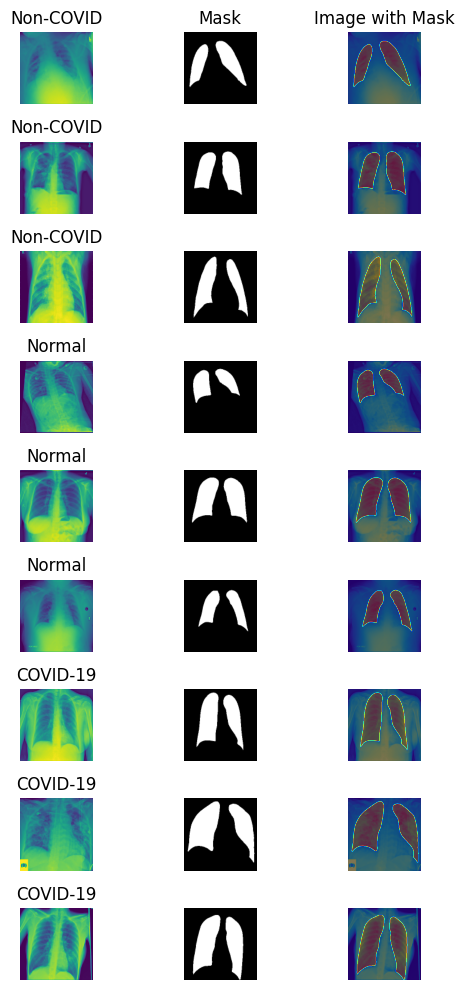

In [11]:
plot(train_df)

# Data Loading

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [13]:
class LungDataset(Dataset):
    def __init__(self, df, transform=None, augmentations=None):
        self.transform = transform
        self.augmentations = augmentations
        
        self.images = df.Images.tolist()
        self.masks = df.Masks.tolist()
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]

        # Open images and masks
        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale mask
        
        if self.transform:
            image, mask = self.transform(image, mask)
            
        if self.augmentations:
            image, mask = self.augmentations(image, mask)
        
        return image, mask

In [14]:
def transform(image, mask):
    image_transform = transforms.Compose([
        transforms.Resize(size=PATCH_SIZE, antialias=True),
        transforms.ToTensor()
    ])
    
    mask_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=PATCH_SIZE, antialias=False)
    ])
    
    return image_transform(image), mask_transform(mask).type(torch.int)

In [15]:
PATCH_SIZE = (128, 128)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16

train_dataset = LungDataset(train_df, transform=transform, augmentations=None)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

val_dataset = LungDataset(val_df, transform=transform, augmentations=None)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_dataset = LungDataset(test_df, transform=transform, augmentations=None)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Model 

UNet Components: Up, DoubleConv, OutConv

In [16]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None, dropout_rate=0.1):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, dropout_rate=dropout_rate)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True, dropout_rate=0.1):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2, dropout_rate=dropout_rate)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels, dropout_rate=dropout_rate)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

UNet Model 

In [17]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, dropout_rate=0.1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64, dropout_rate=dropout_rate))
        self.down1 = (Down(64, 128, dropout_rate=dropout_rate))
        self.down2 = (Down(128, 256, dropout_rate=dropout_rate))
        self.down3 = (Down(256, 512, dropout_rate=dropout_rate))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor, dropout_rate=dropout_rate))
        self.up1 = (Up(1024, 512 // factor, bilinear, dropout_rate=dropout_rate))
        self.up2 = (Up(512, 256 // factor, bilinear, dropout_rate=dropout_rate))
        self.up3 = (Up(256, 128 // factor, bilinear, dropout_rate=dropout_rate))
        self.up4 = (Up(128, 64, bilinear, dropout_rate=dropout_rate))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

Instantiate Model

In [18]:
unet = UNet(1, 2, bilinear=False, dropout_rate=0.1).to(DEVICE)
# unet = nn.DataParallel(unet)
# unet.load_state_dict(torch.load("/kaggle/input/hichic/best_model (1).pth"))

Train 

In [19]:
try:
    import segmentation_models_pytorch as smp
except ImportError:
    !pip install segmentation-models-pytorch -q > /dev/null
    import segmentation_models_pytorch as smp

In [20]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define constants
LEARNING_RATE = 0.001
LR_FACTOR = 0.5
LR_PATIENCE = 2
EARLY_STOP_PATIENCE = 4
NUM_EPOCHS = 50

# Define the loss function, optimizer, and learning rate scheduler
criterion = smp.losses.DiceLoss('multiclass')
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=LR_FACTOR, patience=LR_PATIENCE, verbose=False)

# Initialize early stopping parameters
early_stop_counter = 0
best_val_loss = float('inf')

In [21]:
from tqdm import tqdm
from torch.nn.parallel import DataParallel

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, early_stop_patience=4):
    best_val_loss = float('inf')
    early_stop_counter = 0

    train_losses = []
    val_losses = []

    model = DataParallel(model)
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0

        for batch_idx, (images, masks) in tqdm(enumerate(train_loader), total=len(train_loader)):
            images, masks = images.to(DEVICE), masks.to(DEVICE, dtype=torch.long)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE, dtype=torch.long)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Update learning rate scheduler
        scheduler.step(avg_val_loss)

        # Print and check for early stopping
        print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
            best_val_loss = avg_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_patience:
            print(f'Early stopping after {early_stop_patience} epochs without improvement.')
            break

    return train_losses, val_losses

# Now, call the function with your specific parameters
train_losses, val_losses = train_model(unet, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, early_stop_patience=EARLY_STOP_PATIENCE)

# Load the best model after training
unet = nn.DataParallel(unet) # this is necessary to get matching key dicts
unet.load_state_dict(torch.load('best_model.pth'))

100%|██████████| 1358/1358 [02:37<00:00,  8.60it/s]


Epoch [1/50], Train Loss: 0.0317, Validation Loss: 0.0189


100%|██████████| 1358/1358 [02:36<00:00,  8.67it/s]


Epoch [2/50], Train Loss: 0.0188, Validation Loss: 0.0196


100%|██████████| 1358/1358 [02:36<00:00,  8.67it/s]


Epoch [3/50], Train Loss: 0.0175, Validation Loss: 0.0170


100%|██████████| 1358/1358 [02:37<00:00,  8.64it/s]


Epoch [4/50], Train Loss: 0.0170, Validation Loss: 0.0168


100%|██████████| 1358/1358 [02:37<00:00,  8.65it/s]


Epoch [5/50], Train Loss: 0.0160, Validation Loss: 0.0158


100%|██████████| 1358/1358 [02:37<00:00,  8.65it/s]


Epoch [6/50], Train Loss: 0.0157, Validation Loss: 0.0146


100%|██████████| 1358/1358 [02:37<00:00,  8.64it/s]


Epoch [7/50], Train Loss: 0.0156, Validation Loss: 0.0147


100%|██████████| 1358/1358 [02:36<00:00,  8.65it/s]


Epoch [8/50], Train Loss: 0.0151, Validation Loss: 0.0145


100%|██████████| 1358/1358 [02:36<00:00,  8.66it/s]


Epoch [9/50], Train Loss: 0.0147, Validation Loss: 0.0146


100%|██████████| 1358/1358 [02:36<00:00,  8.66it/s]


Epoch [10/50], Train Loss: 0.0145, Validation Loss: 0.0141


100%|██████████| 1358/1358 [02:37<00:00,  8.64it/s]


Epoch [11/50], Train Loss: 0.0143, Validation Loss: 0.0138


100%|██████████| 1358/1358 [02:36<00:00,  8.67it/s]


Epoch [12/50], Train Loss: 0.0142, Validation Loss: 0.0139


100%|██████████| 1358/1358 [02:36<00:00,  8.67it/s]


Epoch [13/50], Train Loss: 0.0139, Validation Loss: 0.0138


100%|██████████| 1358/1358 [02:36<00:00,  8.66it/s]


Epoch [14/50], Train Loss: 0.0137, Validation Loss: 0.0143


100%|██████████| 1358/1358 [02:37<00:00,  8.64it/s]


Epoch [15/50], Train Loss: 0.0136, Validation Loss: 0.0136


100%|██████████| 1358/1358 [02:37<00:00,  8.64it/s]


Epoch [16/50], Train Loss: 0.0134, Validation Loss: 0.0141


100%|██████████| 1358/1358 [02:37<00:00,  8.65it/s]


Epoch [17/50], Train Loss: 0.0133, Validation Loss: 0.0157


100%|██████████| 1358/1358 [02:37<00:00,  8.65it/s]


Epoch [18/50], Train Loss: 0.0132, Validation Loss: 0.0137


100%|██████████| 1358/1358 [02:37<00:00,  8.65it/s]


Epoch [19/50], Train Loss: 0.0124, Validation Loss: 0.0134


100%|██████████| 1358/1358 [02:37<00:00,  8.65it/s]


Epoch [20/50], Train Loss: 0.0122, Validation Loss: 0.0131


100%|██████████| 1358/1358 [02:36<00:00,  8.67it/s]


Epoch [21/50], Train Loss: 0.0121, Validation Loss: 0.0132


100%|██████████| 1358/1358 [02:36<00:00,  8.66it/s]


Epoch [22/50], Train Loss: 0.0120, Validation Loss: 0.0131


100%|██████████| 1358/1358 [02:36<00:00,  8.66it/s]


Epoch [23/50], Train Loss: 0.0119, Validation Loss: 0.0131


100%|██████████| 1358/1358 [02:36<00:00,  8.67it/s]


Epoch [24/50], Train Loss: 0.0118, Validation Loss: 0.0130


100%|██████████| 1358/1358 [02:36<00:00,  8.67it/s]


Epoch [25/50], Train Loss: 0.0116, Validation Loss: 0.0135


100%|██████████| 1358/1358 [02:36<00:00,  8.67it/s]


Epoch [26/50], Train Loss: 0.0115, Validation Loss: 0.0131


100%|██████████| 1358/1358 [02:36<00:00,  8.70it/s]


Epoch [27/50], Train Loss: 0.0115, Validation Loss: 0.0131


100%|██████████| 1358/1358 [02:36<00:00,  8.70it/s]


Epoch [28/50], Train Loss: 0.0111, Validation Loss: 0.0128


100%|██████████| 1358/1358 [02:36<00:00,  8.70it/s]


Epoch [29/50], Train Loss: 0.0109, Validation Loss: 0.0128


100%|██████████| 1358/1358 [02:36<00:00,  8.69it/s]


Epoch [30/50], Train Loss: 0.0109, Validation Loss: 0.0128


100%|██████████| 1358/1358 [02:36<00:00,  8.70it/s]


Epoch [31/50], Train Loss: 0.0108, Validation Loss: 0.0131


100%|██████████| 1358/1358 [02:36<00:00,  8.67it/s]


Epoch [32/50], Train Loss: 0.0107, Validation Loss: 0.0130


100%|██████████| 1358/1358 [02:37<00:00,  8.64it/s]


Epoch [33/50], Train Loss: 0.0106, Validation Loss: 0.0129


100%|██████████| 1358/1358 [02:37<00:00,  8.64it/s]


Epoch [34/50], Train Loss: 0.0104, Validation Loss: 0.0128
Early stopping after 4 epochs without improvement.


<All keys matched successfully>

Evaluate

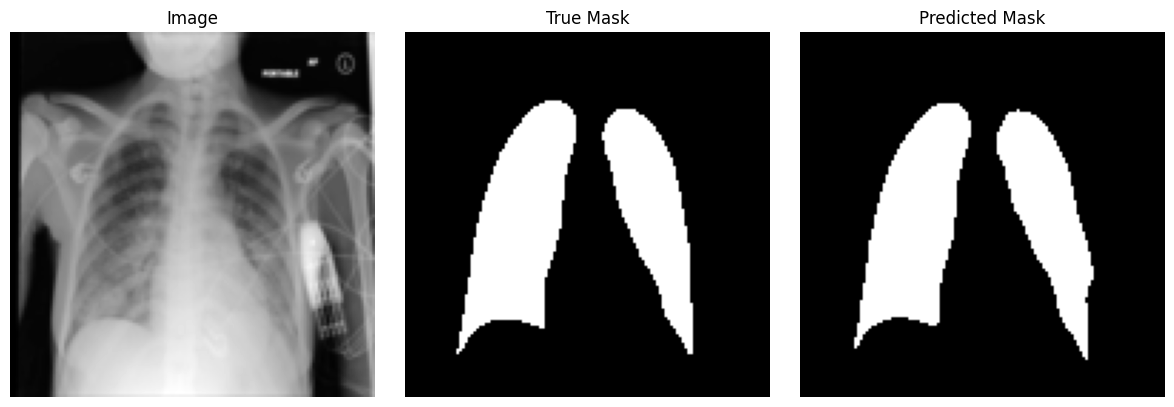

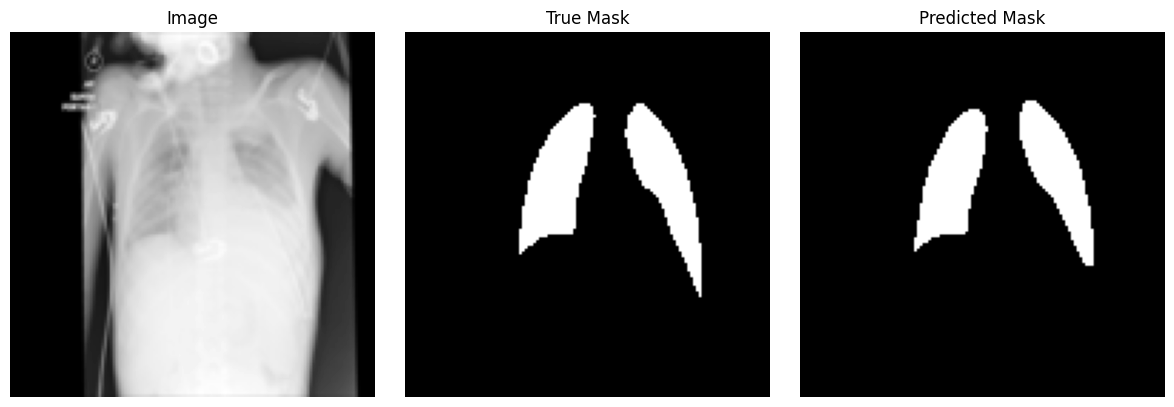

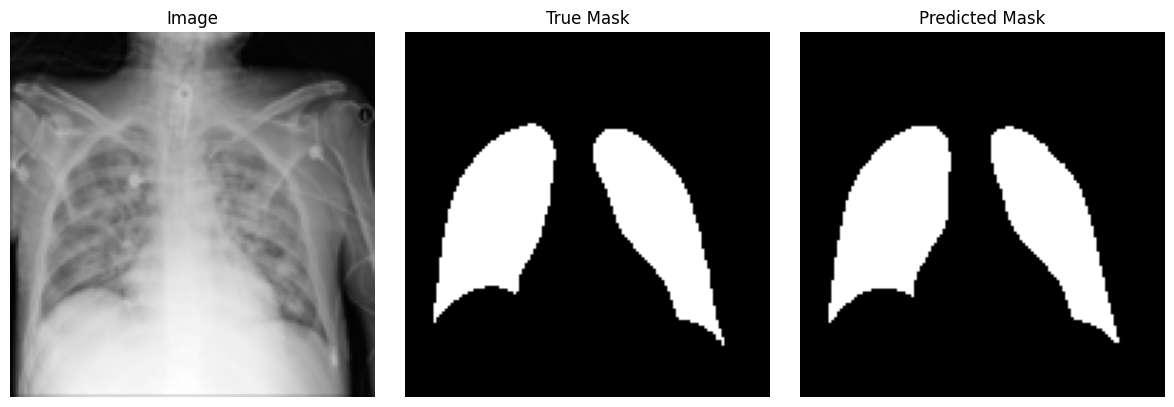

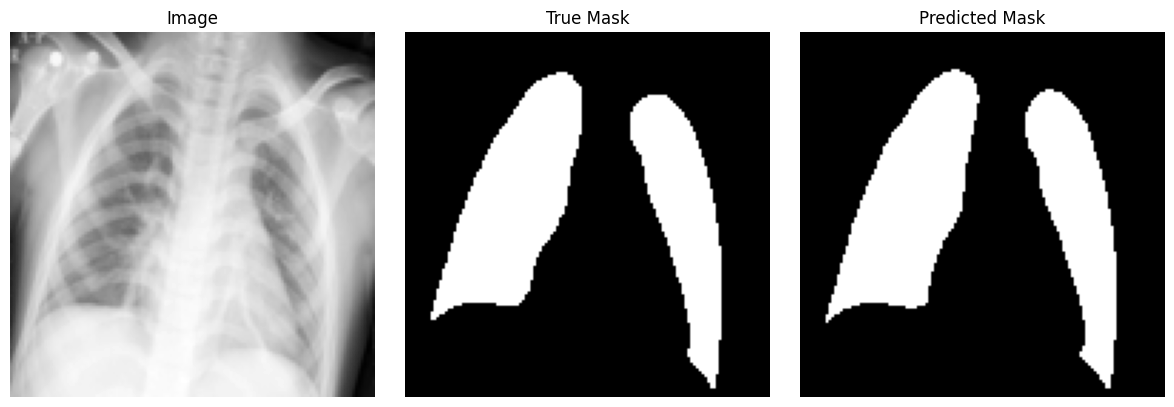

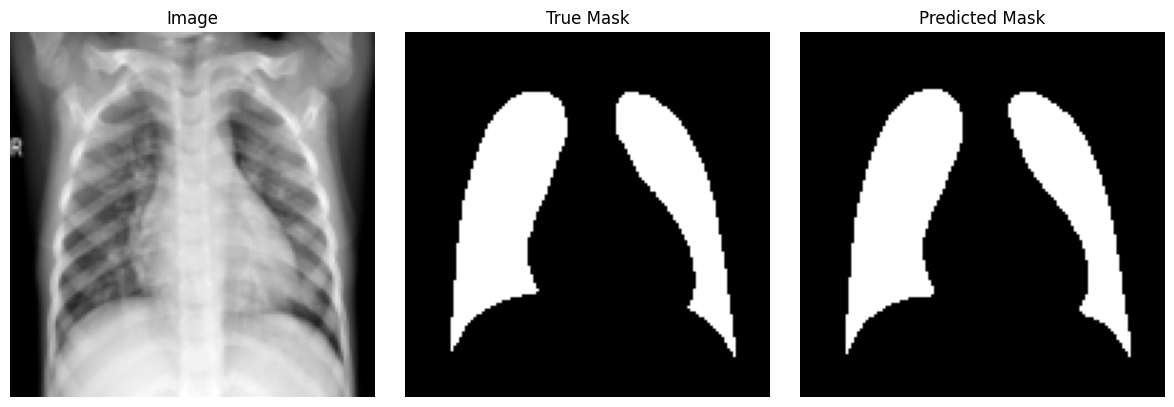

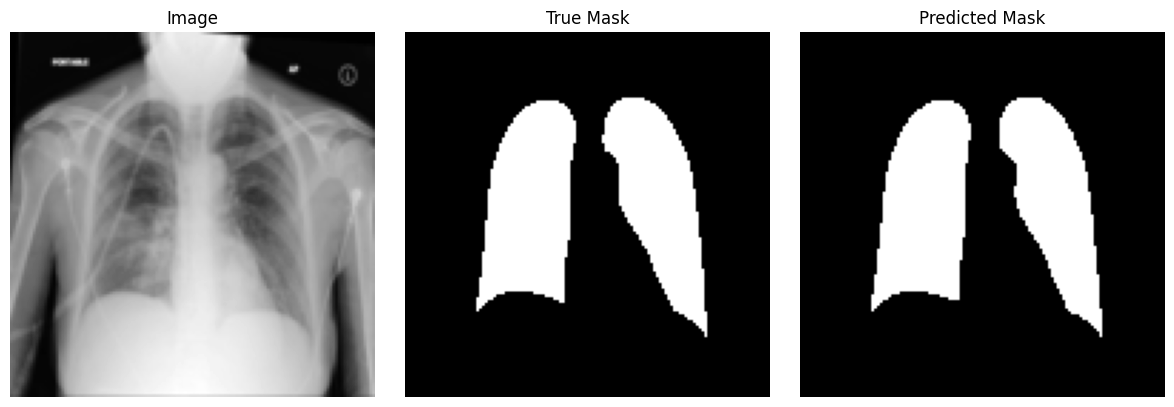

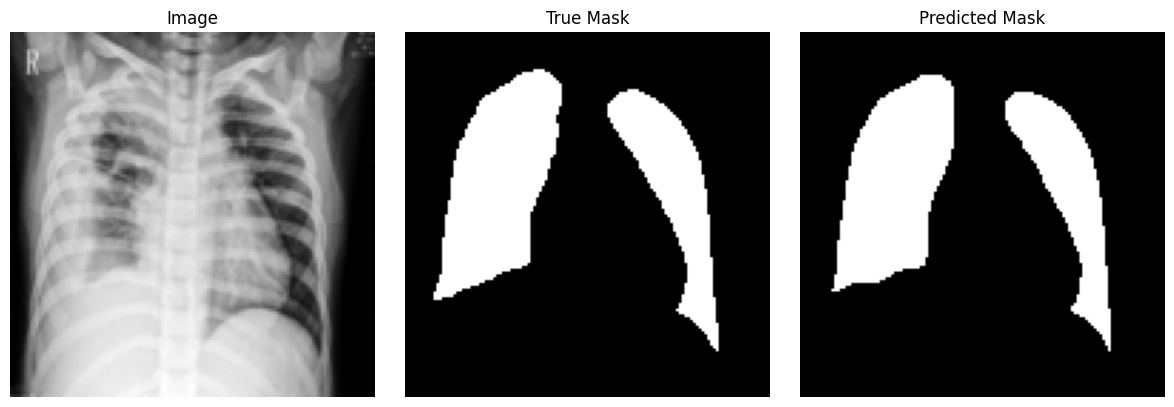

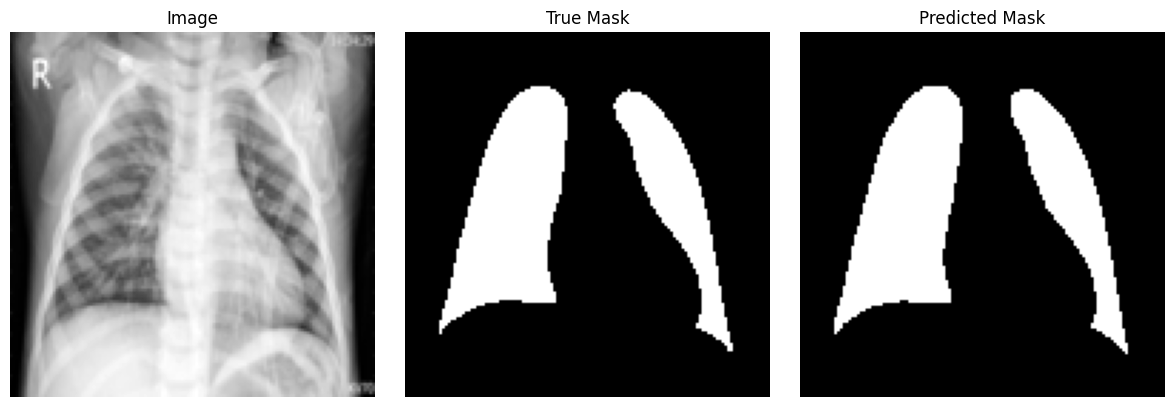

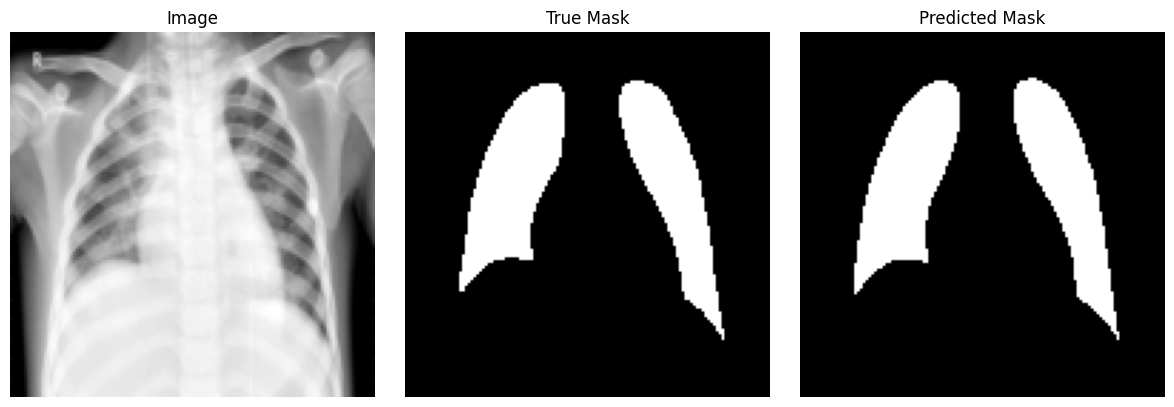

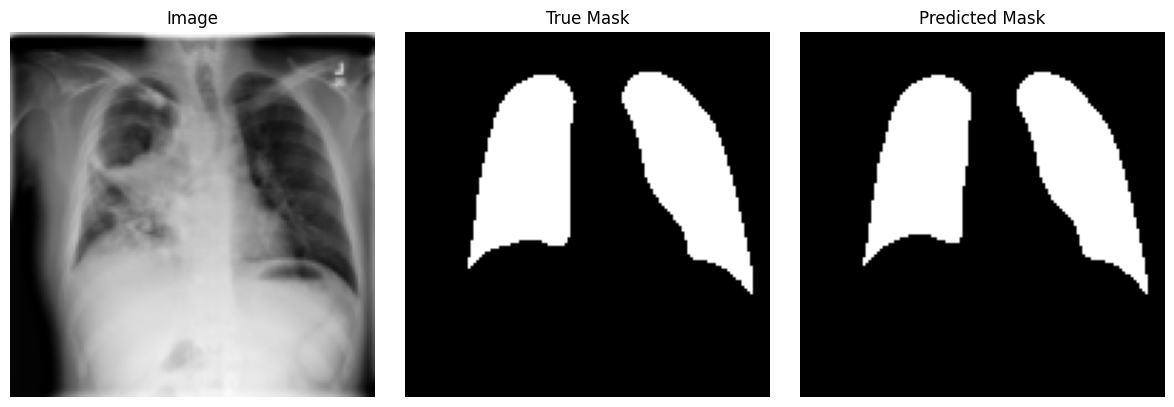

In [22]:
# Function to plot examples with predicted and true masks
def plot_examples(model, dataset, num_examples=5):
    model.eval()
    
    for i in range(num_examples):
        image, mask = dataset[i]
        
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(DEVICE)).cpu()
        
        pred_mask = torch.argmax(output, dim=1)
        
        # Plot the images and masks
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(image.permute(1,2,0), cmap='gray')
        plt.axis("off")
        plt.title('Image')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask.permute(1,2,0), cmap='gray')
        plt.axis("off")
        plt.title('True Mask')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.permute(1,2,0), cmap='gray')
        plt.axis("off")
        plt.title('Predicted Mask')
        
        plt.tight_layout()
        plt.show()

# Plot examples from the test dataloader
plot_examples(unet, test_dataset, num_examples=10)

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, jaccard_score, f1_score, precision_score, recall_score

def compute_metrics(model, dataloader):
    model.eval()
    
    all_true_masks = []
    all_pred_masks = []
    
    confusion = np.zeros((2,2))
    for images, masks in tqdm(dataloader, total=len(dataloader)):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        
        with torch.no_grad():
            outputs = model(images)
        
        # Convert probability maps to binary masks using a threshold
        pred_masks = torch.argmax(outputs, dim=1)
        
        true_masks_np = masks.cpu().detach().numpy().ravel()
        pred_masks_np = pred_masks.cpu().detach().numpy().ravel()
        
        confusion += confusion_matrix(true_masks_np, pred_masks_np)
    
    # Calculate metrics
    TN, FP, FN, TP = confusion.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    jaccard_index = TP / (TP + FP + FN)

    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  IoU      : {jaccard_index:.4f}")
    print(f"  F1 Score : {f1_score:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")

# Ensure DEVICE variable is defined
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Compute metrics for validation set
print("\nMetrics for Validation Set:")
compute_metrics(unet, val_loader)

# Compute metrics for test set (replace test_loader with your actual test dataloader)
print("\nMetrics for Test Set:")
compute_metrics(unet, test_loader)


Metrics for Validation Set:


100%|██████████| 339/339 [00:37<00:00,  8.96it/s]


  Accuracy : 0.9911
  IoU      : 0.9613
  F1 Score : 0.9803
  Precision: 0.9815
  Recall   : 0.9790

Metrics for Test Set:


100%|██████████| 425/425 [00:47<00:00,  8.93it/s]

  Accuracy : 0.9909
  IoU      : 0.9605
  F1 Score : 0.9799
  Precision: 0.9824
  Recall   : 0.9773


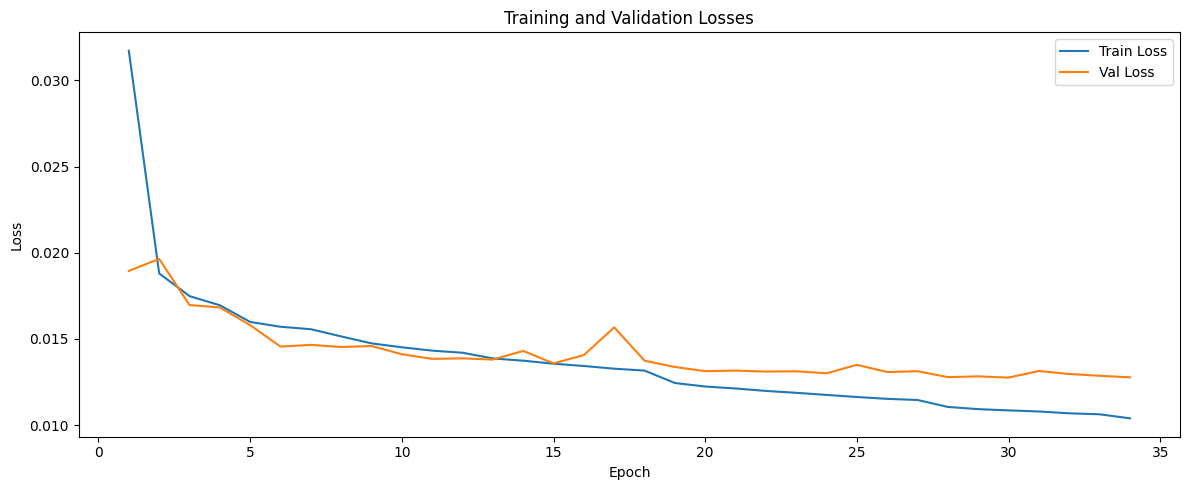

In [24]:
def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().item()

def plot_metrics():
    num_epochs = len(train_losses)
    epochs = np.arange(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics()

In [25]:
# https://www.kaggle.com/code/cornverburg/u-net-lung-segmentation-0-98-iou-99-5-accuracy